# New nlpfuncs for hathi/digitizedwork

In [1]:
%run ppa_nlpdb_get.ipynb

init workcount ... 0.0s
gathering objects to store ... 0.1s
bulk storing ... 0.5s


## Querying for matches

In [2]:
# @NOTE: count in sql -- query annotation

class WordQuery:
    def __init__(self,word_or_words=''):
        words = [word_or_words] if type(word_or_words)==str else word_or_words
        words = [w.strip() for w in words if w.strip()]
        self.words = words
        self.wordset = set(words)
        self._qset = None
        self._meta = None
        self._data = None
        
    def get_queryset(self):
        if self._qset is None:
            with timer('getting queryset'):
                self._qset=WordCount.objects.filter(word__in=self.wordset).select_related('work')
                # @TODO one to one may fix this
                
        return self._qset

    def get_works(self): return [wwc.work for wwc in self.get_queryset()]
    
    def get_data(self,force=False):
        if self._data is None or force:
            with timer('gathering data'):
                odf=pd.DataFrame(
                    dict(
                        work=wwc.work.id,
                        word=wwc.word,
                        count=wwc.count,
                        total=wwc.work.get_total_count(),
                    )
                    for wwc in self.get_queryset()
                    if wwc.word in self.wordset
                )
                if len(odf):
                    odf['fpm'] = odf['count'] / odf['total'] * 10**6
                self._data = odf
        return self._data
    
    def get_meta(self, keys = ['source_id','title','author','pub_date'], force=False):
        if self._meta is None or force:
            with timer('gathering metadata'):
                self._meta = pd.DataFrame(
                    dict(
                        work=work.id,
                        **{k:getattr(work,k) for k in keys}
                    )
                    for work in self.get_works()
                )
        return self._meta
    
    def get_all(self, **opts):
        data = self.get_data()
        meta = self.get_meta()
        return data.merge(meta,on='work',how='left')


In [3]:
qwords=[
    'ballad',
    'epic',
    'verse',
    'sonnet',
    'stanza',
    'poem',
    'ode',
    'elegy'
]

In [8]:
wq = WordQuery(['ballad'])
wq

In [9]:
qset=wq.get_queryset()
qset

getting queryset ... 0.0s


<QuerySet [WordCount(Work(3), "ballad", 1), WordCount(Work(4), "ballad", 41), WordCount(Work(5), "ballad", 7), WordCount(Work(6), "ballad", 4), WordCount(Work(7), "ballad", 3), WordCount(Work(8), "ballad", 13), WordCount(Work(9), "ballad", 5), WordCount(Work(10), "ballad", 2), WordCount(Work(11), "ballad", 10), WordCount(Work(12), "ballad", 3), WordCount(Work(13), "ballad", 9), WordCount(Work(14), "ballad", 8), WordCount(Work(15), "ballad", 13), WordCount(Work(16), "ballad", 7), WordCount(Work(18), "ballad", 11), WordCount(Work(19), "ballad", 7), WordCount(Work(23), "ballad", 3), WordCount(Work(24), "ballad", 1), WordCount(Work(25), "ballad", 39), WordCount(Work(26), "ballad", 1), '...(remaining elements truncated)...']>

In [10]:
# Get all data from db and pack into dataframe
wq.get_data()

gathering data ... 1.8s


,work,word,count,total,fpm
0,3,ballad,1,194992,5.128416
1,4,ballad,41,511199,80.203600
2,5,ballad,7,886956,7.892162
3,6,ballad,4,831893,4.808311
4,7,ballad,3,588559,5.097195
...,...,...,...,...,...
2592,5098,ballad,19,60379,314.678945
2593,6309,ballad,38,260738,145.740168
2594,6310,ballad,1,191891,5.211292
2595,6327,ballad,7,255318,27.416790


In [7]:
# Get all relevant text metadata
wq.get_meta()

gathering metadata ... 0.0s


,work,source_id,title,author,pub_date
0,3,chi.79279237,Speaking to the Psaltery,"Yeats, W. B.",1902
1,4,chi.79213384,Rhyme nor Reason,[none],1866
2,5,chi.78323978,English Rhythm,"Alden, Raymond Macdonald",1911
3,6,chi.78323841,English Verse: Specimens Illustrating Its Prin...,[none],1903
4,7,chi.78023993,The Expressive Power of English Sounds,"Tolman, Albert H",1895
...,...,...,...,...,...
2595,5098,uiug.30112001676896,Sapphics,"Swinburne, Algernon Charles.",1866
2596,6309,mdp.39015078153817,Lesser Verse Writers,"Saintsbury, George.",1913
2597,6310,njp.32101074834787,An Essay on Rythmical Measures,"Young, Walter",1790
2598,6327,mdp.39015043572422,The 'Five Types' in Anglo-Saxon Verse,"Greg, W. W.",1925


In [7]:
# Join them together
wq.get_all()

,work,word,count,total,fpm,source_id,title,author,pub_date
0,3,ballad,1,194992,5.128416,chi.79279237,Speaking to the Psaltery,"Yeats, W. B.",1902
1,4,ballad,41,511199,80.203600,chi.79213384,Rhyme nor Reason,[none],1866
2,5,ballad,7,886956,7.892162,chi.78323978,English Rhythm,"Alden, Raymond Macdonald",1911
3,6,ballad,4,831893,4.808311,chi.78323841,English Verse: Specimens Illustrating Its Prin...,[none],1903
4,7,ballad,3,588559,5.097195,chi.78023993,The Expressive Power of English Sounds,"Tolman, Albert H",1895
...,...,...,...,...,...,...,...,...,...
2592,5098,ballad,19,60379,314.678945,uiug.30112001676896,Sapphics,"Swinburne, Algernon Charles.",1866
2593,6309,ballad,38,260738,145.740168,mdp.39015078153817,Lesser Verse Writers,"Saintsbury, George.",1913
2594,6310,ballad,1,191891,5.211292,njp.32101074834787,An Essay on Rythmical Measures,"Young, Walter",1790
2595,6327,ballad,7,255318,27.416790,mdp.39015043572422,The 'Five Types' in Anglo-Saxon Verse,"Greg, W. W.",1925


In [8]:
# Save
wq.get_all().sort_values('fpm', ascending=False).to_csv('data.ballad_count.csv',index=False)

In [9]:
import plotnine as p9
p9.options.figure_size=11,8

class WordQueryPlot:
    def __init__(self,wordquery,title=None):
        self.wq = wordquery
        if title is None:
            title = f'Word Query Plot ({", ".join(self.wq.words)})' 
        self.title=title
    
    @property
    def data(self):
        df = self.wq.get_all().query('total>10000 & 1800<pub_date<2000')
        top = df.groupby('word').fpm.sum().sort_values(ascending=False)
        df['word'] = pd.Categorical(df['word'], categories=top.index)
        df['fp100k'] = df['fpm'] / 10
        return df
    
    @property
    def data_yearavgs(self):
        return self.data.groupby(['word','pub_date']).mean().reset_index()
    

    def plot(self):    
        return (
            p9.ggplot(
                self.data,
                p9.aes(
                    x='pub_date',
                    y='fp100k',
                    color='word',
                )
            )
            + p9.facet_wrap('word')
            + p9.geom_point(size=.5, alpha=.25)
            + p9.geom_smooth(method='loess',se=False)
            + p9.scale_y_log10()
            + p9.theme_minimal()
            + p9.theme(text=p9.element_text(size=11))
            + p9.labs(
                title=self.title,
            )
        )

    def plot_yearavgs(self,year_avgs=False):    
        fig = (
            p9.ggplot(
                self.data_yearavgs,
                p9.aes(
                    x='pub_date',
                    y='fp100k',
                    color='word',
                    group='word',
                    text='word'
                )
            )
            + p9.facet_wrap('word')
            + p9.geom_point(size=1, alpha=.5)
            + p9.geom_smooth(method='loess',se=True)
            + p9.scale_y_log10()
            + p9.theme_minimal()
            + p9.theme(text=p9.element_text(size=11))
            + p9.labs(
                title=f'{self.title}, averaged by year'
            )
        )
        return fig


gathering data ... getting queryset ... 0.0s
41.1s
gathering metadata ... 0.0s


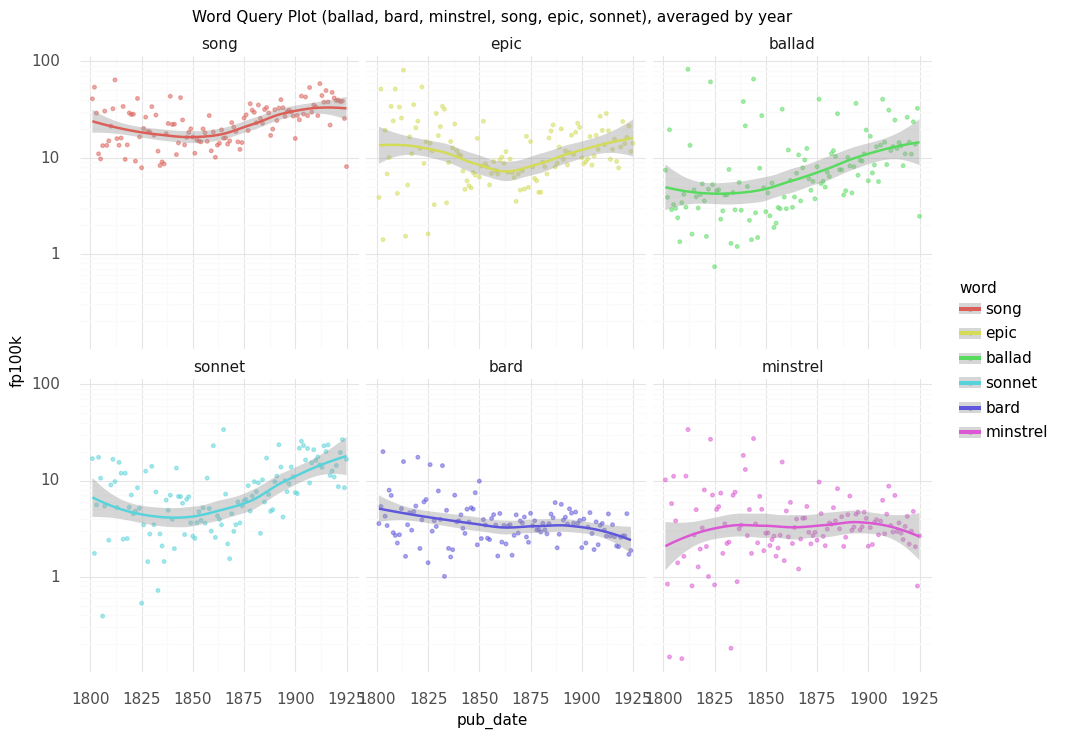

<ggplot: (716850390)>

In [10]:
wqp = WordQueryPlot(WordQuery(['ballad','bard','minstrel','song','epic','sonnet']))
wqp.plot_yearavgs()


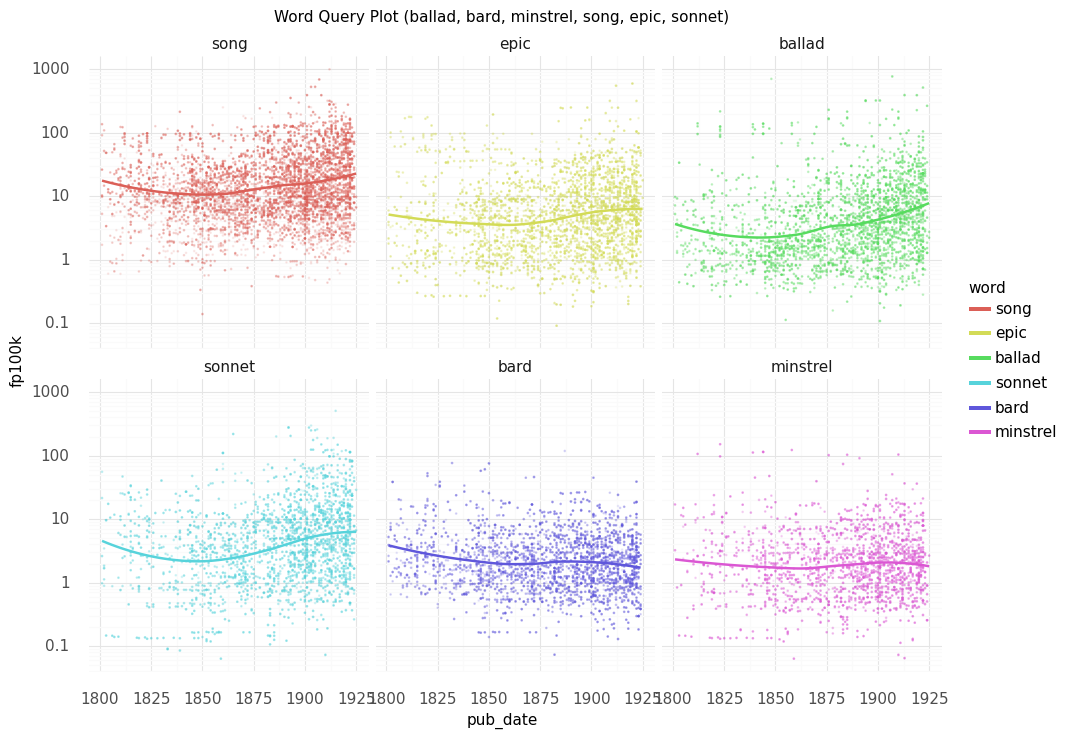

<ggplot: (673322596)>

: 

In [ ]:
wqp.plot()

gathering data ... getting queryset ... 0.0s
1.8s
gathering metadata ... 0.0s


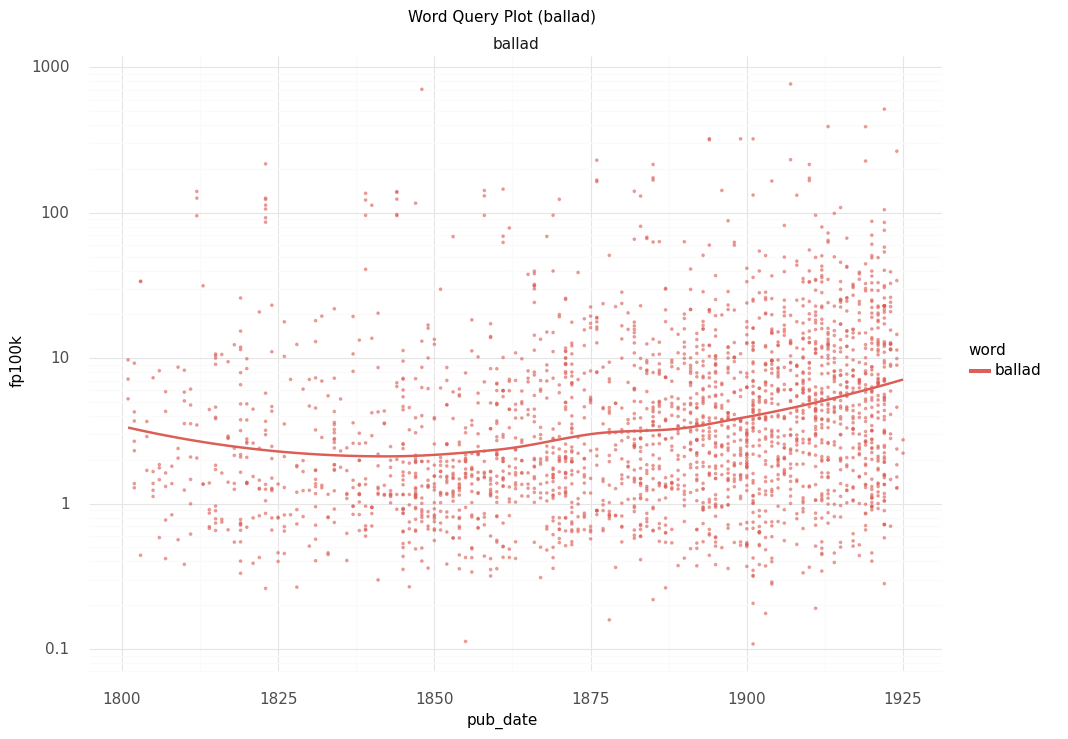

<ggplot: (677059356)>

In [21]:
WordQueryPlot(WordQuery('ballad')).plot()